# Production Readiness & Monitoring – Operating Fraud Systems at Scale

This notebook focuses on **operating a fraud detection system in production**.

The goal is not infrastructure implementation,
but demonstrating **production thinking**:
- what can go wrong after deployment,
- how we detect issues early,
- how the business responds in a controlled way.

This is where models become **long-lived systems**.


## What Does Production-Ready Mean?

A production-ready fraud system must:
- maintain performance over time,
- adapt to changing fraud patterns,
- operate within business and regulatory constraints.

In practice, models rarely fail because of bad code.
They fail because **reality changes**.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

paths = ["data/creditcard.csv", "creditcard.csv"]
data_path = next((p for p in paths if os.path.exists(p)), None)

if data_path is None:
    raise FileNotFoundError("creditcard.csv not found.")

df = pd.read_csv(data_path)
df.shape


(284807, 31)

## Reference Model for Monitoring

All monitoring compares current behavior
against a **validated reference period**.

We reuse the supervised risk model
as a stable baseline for comparison.


In [2]:
X = df.drop(columns=["Class"])
y = df["Class"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, stratify=y, random_state=42
)

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

model = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    eval_metric="logloss",
    random_state=42
)

model.fit(X_train, y_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [3]:
reference_scores = model.predict_proba(X_test)[:, 1]
reference_auc = roc_auc_score(y_test, reference_scores)

reference_auc


0.971664913345258

## Common Production Failure Modes

1. **Data drift** – input distributions change
2. **Concept drift** – fraud strategies evolve
3. **Label delay** – ground truth arrives late
4. **Policy drift** – thresholds change without recalibration
5. **Operational overload** – review queues explode

Monitoring exists to detect these *before* they cause damage.


## Simulating Data Drift (Conceptual)

To illustrate monitoring mechanics,
we simulate drift by perturbing feature distributions.

The goal is not realism,
but demonstrating **how drift is detected**.


In [4]:
rng = np.random.default_rng(42)

X_drifted = X_test.copy()
drift_strength = 0.2

# Apply drift to a subset of features
for i in range(int(X_drifted.shape[1] * 0.2)):
    X_drifted[:, i] += rng.normal(0, drift_strength, size=X_drifted.shape[0])


## Prediction Drift Monitoring

A simple and effective early signal:
**Has the distribution of risk scores changed?**

Large shifts often indicate:
- upstream data issues,
- new fraud behavior,
- broken feature pipelines.


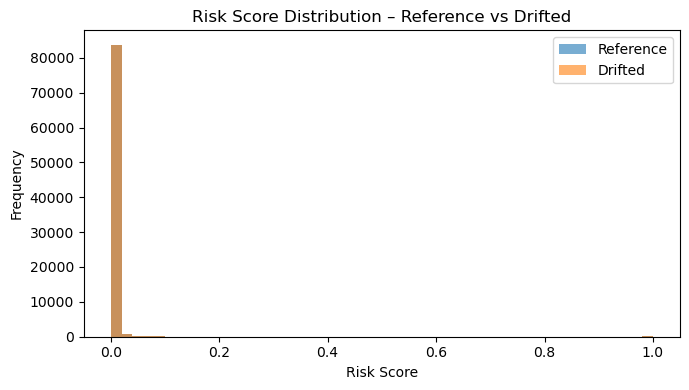

In [5]:
drifted_scores = model.predict_proba(X_drifted)[:, 1]

plt.figure(figsize=(7, 4))
plt.hist(reference_scores, bins=50, alpha=0.6, label="Reference")
plt.hist(drifted_scores, bins=50, alpha=0.6, label="Drifted")
plt.title("Risk Score Distribution – Reference vs Drifted")
plt.xlabel("Risk Score")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()


## Business Interpretation

A shift in score distribution implies:
- different block / review / allow volumes,
- changed operational workload,
- altered fraud exposure.

Even without labels,
this provides an **early warning**.


## Monitoring with Delayed Labels

Fraud labels often arrive days or weeks later.
Therefore monitoring relies on:

- leading indicators (scores, volumes),
- rolling evaluation on recent labeled windows,
- patience to avoid reacting to noise.


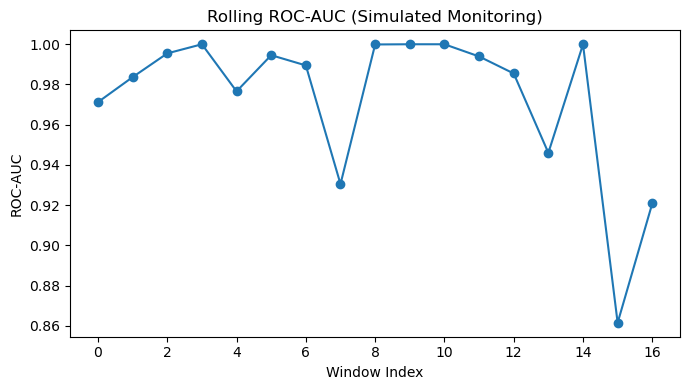

In [6]:
window_size = 5000
aucs = []

for start in range(0, len(X_test) - window_size, window_size):
    end = start + window_size
    auc = roc_auc_score(
        y_test.iloc[start:end],
        reference_scores[start:end]
    )
    aucs.append(auc)

plt.figure(figsize=(7, 4))
plt.plot(aucs, marker="o")
plt.title("Rolling ROC-AUC (Simulated Monitoring)")
plt.xlabel("Window Index")
plt.ylabel("ROC-AUC")
plt.tight_layout()
plt.show()


## Monitoring Operational Metrics

Production teams monitor more than model metrics:

- review rate,
- block rate,
- allow rate,
- fraud concentration per bucket.

Operational drift often appears **before** performance drift.


In [7]:
threshold_review = 0.3
review_rate = (reference_scores >= threshold_review).mean()
review_rate


np.float64(0.0027971864283791534)

## Alerting and Response Playbooks

Monitoring must be paired with predefined actions:

- **Score drift detected:** investigate data pipelines
- **Review rate spike:** adjust thresholds temporarily
- **Performance drop:** retrain or recalibrate model
- **New fraud pattern:** update features or rules

Monitoring without response plans creates alert fatigue.


## Retraining Strategy

Retraining is triggered by:
- sustained performance degradation,
- confirmed fraud pattern shifts,
- major product or business changes.

Retraining too often causes instability.
Retraining too rarely increases risk.

The optimal cadence balances **stability and adaptability**.


## Governance & Explainability

In production:
- decisions must be auditable,
- explanations must be reproducible,
- policies must be documented.

Explainability tools support:
- regulatory inquiries,
- internal audits,
- customer dispute resolution.


## Failure Mode Summary

| Risk | Detection Signal | Response |
|---|---|---|
| Data drift | Score distribution shift | Pipeline check |
| Concept drift | Rolling metric drop | Retrain |
| Ops overload | Review rate spike | Policy adjust |
| Label delay | Leading indicators | Wait & monitor |

Production readiness is about **anticipating failure**.


## Key Takeaways

- Fraud models must be monitored continuously after deployment.
- Early warning signals often come from **distributions and volumes**, not labels.
- Monitoring must connect model behavior to operational impact.
- Clear response playbooks are as important as detection itself.

> In production, success is not a high AUC,
> but a system that **fails slowly and predictably**.
